In [31]:
import sys
sys.path.append('/Users/jayzee/Documents')
import os
import discogs_env
import oauth2 as oauth
import re
import requests
!pip install Selenium
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
import json
import pandas as pd
import numpy as np
!pip install matplotlib
import matplotlib.pyplot as plt

In [32]:
### Example Input Parameters
my_username = discogs_env.discogs_user()
my_password = discogs_env.discogs_pw()
my_user_agent = "camilla/1.0"

In [33]:
def create_app(username, password):
    """
    Creates an application, where the user must enter their full name and description, returns consumer key and secret.

    
    Parameters
    ----------
    username : str
        A string of the user's username
    password : str
        A string of the user's password


    Returns
    -------
    str
        A string of the user's unique consumer key
    str
        A string of the user's unique consumer secret

    """
    driver = webdriver.Chrome()
    options = webdriver.ChromeOptions()
    
    # prevent site from detecting automated test software
    options.add_experimental_option("useAutomationExtension", False)
    options.add_experimental_option("excludeSwitches",["enable-automation"])
    
    # driver = webdriver.Chrome(executable_path=driver_path, chrome_options=options)
    driver = webdriver.Chrome(chrome_options=options)

    # go to developer url
    developer_url = "https://www.discogs.com/settings/developers"
    driver.get(developer_url)

    # find username/email field and send the username itself to the input field
    driver.find_element(By.ID, "username").send_keys(username)
    # find password input field and insert password as well
    driver.find_element(By.ID, "password").send_keys(password)
    # click login button
    driver.find_element(By.XPATH, "//button[@type ='submit']").click()

    # click button to create app
    driver.find_element(By.XPATH, "//a[@href='/applications/edit']").click()
    
    # find username/email field and send the username itself to the input field
    driver.find_element(By.XPATH, "/html/body/div[1]/div[4]/div/form/fieldset[1]/div[1]/input").send_keys(str(input("Please enter your full name ")))
    # find password input field and insert password as well
    driver.find_element(By.XPATH, "/html/body/div[1]/div[4]/div/form/fieldset[1]/div[2]/textarea").send_keys(str(input("Please enter a description ")))

    # click to confirm create application 
    button = driver.find_element(By.XPATH, """/html/body/div[1]/div[4]/div/form/fieldset[2]/button""")
    driver.execute_script("arguments[0].click();", button)

    # get consumer Key
    your_consumer_key = driver.find_element(By.XPATH, """//*[@id="page_content"]/table/tbody/tr[1]/td[2]/code""").text

    # get consumer secret
    your_consumer_secret = driver.find_element(By.XPATH, "/html/body/div[1]/div[4]/div/table/tbody/tr[2]/td[2]/code").text
    return(your_consumer_key, your_consumer_secret)

In [34]:
my_consumer_key, my_consumer_secret = create_app(my_username, my_password)

/var/folders/3q/9y1bc97d38sb9fbk86h0c3zc0000gn/T/ipykernel_33259/171503277.py:11: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(chrome_options=options)


Please enter your full name Camilla hehe
Please enter a description desc


In [35]:
def get_tokens(user_agent, your_consumer_key, your_consumer_secret):
    """
    Generates and returns authentication token 

    
    Parameters
    ----------
    user_agent : str
        String of the user's user_agent
    consumer_key : str
        String of the user's unique consumer key
    consumer_secret : str
        String of the user's unique consumer secret

            
    Returns
    -------
    str
        String of the user's authentication token
    str
        String of the user's authentication secret
    """

    request_url = "https://api.discogs.com/oauth/request_token"
    consumer = oauth.Consumer(key =your_consumer_key, secret=your_consumer_secret)
    client = oauth.Client(consumer)
    headers = {"Content-Type": "application/x-www-form-urlencoded",
                "User-Agent": user_agent}

    r, token_content = client.request(
                    request_url,
                    method = "PUT",
                    headers=headers
                    )
    print(r['status'])

    # extract oauth token from content
    token_content = str(token_content)
    start = "b'oauth_token="
    end = '&'

    assert r['status'] !=200, "An error occured" # if the token was not successfully produced then raise an assertion

    oauth_token = re.search('%s(.*)%s' % (start, end), token_content).group(1)
    oauth_token_secret = re.search("token_secret=(.+?)'", token_content).group(1)
    return(oauth_token, oauth_token_secret)

In [36]:
my_oauth_token, my_oauth_token_secret = get_tokens(my_user_agent, my_consumer_key, my_consumer_secret)

200


In [37]:
def authorize_token(username, password, oauth_token):
    """
    Authorize authentication token credentials and returns a code for future verification.

    
    Parameters
    ----------
    username : str
        String of the user's username
    password : str
        String of the user's password
    oauth_token : str
        String of the user's authentication token

            
    Returns
    -------
    str
        String of the user's code
    """
   
    driver = webdriver.Chrome()
    options = webdriver.ChromeOptions()
    # prevent site from detecting automated test software
    options.add_experimental_option("useAutomationExtension", False)
    options.add_experimental_option("excludeSwitches",["enable-automation"])
    #driver = webdriver.Chrome(executable_path=driver_path, chrome_options=options)
    driver = webdriver.Chrome(chrome_options=options)
    driver.get("https://www.discogs.com/oauth/authorize?oauth_token="+oauth_token)

    # find username/email field and send the username itself to the input field
    driver.find_element(By.ID, "username").send_keys(username)
    # find password input field and insert password as well
    driver.find_element(By.ID, "password").send_keys(password)

    # click login button
    driver.find_element(By.XPATH, "//button[@type ='submit']").click()

    # click Authorize button
    driver.find_element(By.XPATH, "//button[@class='button button-green']").click()
    
    # get Authorization code
    code = driver.find_element(By.TAG_NAME, 'pre').text
    return(code)

In [39]:
my_code = authorize_token(my_username, my_password, my_oauth_token)

/var/folders/3q/9y1bc97d38sb9fbk86h0c3zc0000gn/T/ipykernel_33259/1190938235.py:10: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(chrome_options=options)


In [40]:
def get_access_tokens(username, password, consumer_key, consumer_secret, user_agent):
        """
    Returns access token and secret access token for retrieving data

    
    Parameters
    ----------
    username : str
        String of the user's username
    password : str
        String of the user's password
    consumer_key : str
        String of the user's unique consumer key
    consumer_secret : str
        String of the user's unique consumer secret
    user_agent : str
        String of the user's user_agent
            
            
    Returns
    -------
    str
        String of the user's access token
    str
        String of the user's access token secret
    """
 
    
    #Get oauth token, token secret, and code 
    oauth_token, oauth_token_secret = get_tokens(user_agent, consumer_key, consumer_secret)
    code = authorize_token(username, password, oauth_token)
    
    #Get token from oauth token and oauth token secret
    
    token = oauth.Token(oauth_token, oauth_token_secret)
    token.set_verifier(code) # Verification code
    
    consumer = oauth.Consumer(key = consumer_key, secret=consumer_secret)
    client = oauth.Client(consumer, token)
    myheaders = {"Content-Type": "application/x-www-form-urlencoded",
                "User-Agent": user_agent}

    access_url = "https://api.discogs.com/oauth/access_token"
    r, content2 = client.request(
                    access_url,
                    method = "POST",
                    headers=myheaders
                    )
    print(r['status'])
    assert r['status'] !=200, "An error occured" #If the token was not successfully produced then raise an assertion

    #Extract access token from content
    token_content2 = str(content2)
    start = "b'oauth_token="
    end = '&'

    access_token = re.search('%s(.*)%s' % (start, end), token_content2).group(1)
    access_token_secret = re.search("token_secret=(.+?)'", token_content2).group(1)
    return(access_token, access_token_secret)

In [41]:
my_access_token, my_access_token_secret = get_access_tokens(my_username, my_password, my_consumer_key, my_consumer_secret, my_user_agent)

200


/var/folders/3q/9y1bc97d38sb9fbk86h0c3zc0000gn/T/ipykernel_33259/1190938235.py:10: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(chrome_options=options)


200


In [43]:
# Function to attain information on artist releases based on selected artist of user's choosing
def get_releases_data(artist_id_list, access_token, access_token_secret, consumer_key, consumer_secret, user_agent):
    """
    This function obtains List containing a list of artist ID numbers chosen by the user. There is no limit to the number of artists.
    IDs can be found on the top right corner of the artist's Discogs resource URL, and is followed by one alphabetic character, enclosed within brackets
    Returns a dataframe containing information on all the releases (albums, appearances, soundtracks, etc.) of the selected artists.

    
    Parameters
    ----------
    artist_id_list : list
        List containing a list of artist IDs 
    access_token : str
        String of the user's access token
    access_token_secret : str
        String of the user's access token secret
    consumer_key : str
        String of the user's unique consumer key
    consumer_secret : str
        String of the user's unique consumer secret
    user_agent : str
        String of the user's user_agent

            
    Returns
    -------
    pandas.DataFrame
        Dataframe containing release_id, title, artist, year, etc of each release and each artist
    """
        
    # empty dataframe for all artists:
    df = pd.DataFrame()

    for artist_id in artist_id_list: 

        # get number of pages describing releases of artist
        access_tokens = oauth.Token(access_token, access_token_secret) # attach OAuth access token and access token secret to request
        consumer = oauth.Consumer(key = consumer_key, secret = consumer_secret)
        client = oauth.Client(consumer, access_tokens)
        r, content = client.request("https://api.discogs.com/artists/"+str(artist_id)+"/releases", # artist releases
                                    method = "GET",
                                    headers={'User-Agent': user_agent}
                                    )
        content_cleaned = json.loads(content.decode('utf-8'))
        pages = content_cleaned['pagination']['pages'] # number of pages

        # iterate through each page and append
        artist_df = pd.DataFrame() # empty dataframe for all releases
        count=0
        for i in range(pages):
            count+=1 # page counter
            access_tokens = oauth.Token(access_token, access_token_secret) # attach OAuth access token and access token secret to request
            consumer = oauth.Consumer(key = consumer_key, secret=consumer_secret)
            client = oauth.Client(consumer, access_tokens)
            r, content = client.request("https://api.discogs.com/artists/"+str(artist_id)+"/releases?page="+str(count), # artist Releases
                                        method = "GET",
                                        headers={'User-Agent': user_agent}
                                        )
            content_cleaned = json.loads(content.decode('utf-8'))

            # create empty DataFrame for each artist
            releases_df = pd.DataFrame(columns = ["id", "title", "artist", "year", "role", "stats"])

            # iterating over each release
            for i in content_cleaned['releases']:
                releases_df.loc[len(releases_df)] = i # converts each information of a release as a row in a dataframe
            # rename ID into release ID (not to get confused w/artist ID)
            releases_df.rename(columns = {'id':'release_id'}, inplace = True)
            releases_df['artist_id'] = artist_id
            releases_df["stats"].astype(str) #Convert stats to string

            # get number of wantlisters and collectors
            wantlist_list = [re.search("community': {'in_wantlist': ([0-9]*),", str(s)).group(1) for s in releases_df["stats"]] # get number users who added this to their wantlist 
            collection_list = [re.search("'in_collection': ([0-9]*)},", str(s)).group(1) for s in releases_df["stats"]] # get users who have this in their collection already
            releases_df['in_wantlist'] = wantlist_list # append wantlisters
            releases_df['in_collection'] = collection_list # append collectors
            # clean data
            releases_df2 = releases_df.dropna(subset=['release_id']) # remove NA columns
            releases_df2 = releases_df2.drop(['stats'], axis = 1) # remove original stats column

            # append each page of artists data to full artist data
            artist_df = pd.concat([artist_df, releases_df2])

        # populate data with full artist data
        df = pd.concat([df, artist_df]) 

    df.reset_index(drop=True, inplace=True) # fix index
    return(df)

In [44]:
artist_id_list = [160904, 2508414] # 160904 = Seals & Crofts, 2508414 = Harry Styles
my_releases_df = get_releases_data(artist_id_list, my_access_token, my_access_token_secret, my_consumer_key, my_consumer_secret, my_user_agent)
my_releases_df.head(10)

,release_id,title,artist,year,role,artist_id,in_wantlist,in_collection
0,540125,Seals And Crofts,Seals And Crofts*,1969.0,Main,160904,79,347
1,6093218,Cotton Mouth,Seals & Crofts,1970.0,Main,160904,5,3
2,10846567,See My Life / In Tune / Hollow Reed / Leave,Seals And Crofts*,1970.0,Main,160904,2,3
3,1659565,In Tune,Seals & Crofts,1970.0,Main,160904,0,0
4,928474,Gabriel Go On Home / Robin,Seals And Crofts*,1970.0,Main,160904,2,6
5,2327392,See My Life,Seals & Crofts,1970.0,Main,160904,0,0
6,855923,Ridin' Thumb,Seals & Crofts,1970.0,Main,160904,3,4
7,540126,Down Home,Seals & Crofts,1970.0,Main,160904,51,963
8,540127,Year Of Sunday,Seals & Crofts,1971.0,Main,160904,48,1029
9,564215,When I Meet Them,Seals & Crofts,1971.0,Main,160904,2,6


In [18]:
#Function to deliver summary statistics of artist releases
def summary_stats_by_artist(df):
    """
    This function obtains the dataframe from containing information on artist releases and returns summary statistics by artist.
    Summary statistics include average collectors or wantlisters for each artist, and years active.

    
    Parameters
    ----------
    df : pandas.DataFrame
        pandas.Dataframe containing release_id, title, artist, year, etc of each release and each artist

            
    Returns
    -------
    pandas.DataFrame
        Summary statistics by artist
    """    
    
    ## Get average number releases added into wantlist and collection ##
    df[['in_wantlist', 'in_collection']] = df[['in_wantlist', 'in_collection']].astype("float32")
    want_collect_avgs = df[['artist_id', 'in_wantlist', 'in_collection']].groupby('artist_id').mean()
    want_collect_avgs = want_collect_avgs.reset_index()
    want_collect_avgs.rename(columns = {'in_wantlist':'wantlisted_avg', 'in_collection':'collected_avg'}, inplace = True)

    ## Get total number of releases ##
    release_counts = df[["release_id", "artist_id"]].groupby('artist_id').count()
    release_counts = release_counts.reset_index()
    release_counts = release_counts.rename(columns = {'release_id':'release_count'})

    # merge release and wantlist data
    summary_half = pd.merge(want_collect_avgs, release_counts, on = 'artist_id') 
    
    ## Get the years active of an artist ##
    min_max_yr = df.groupby('artist_id').agg({'year' : [np.min, np.max]})
    min_max_yr = min_max_yr.reset_index()
    min_max_yr = min_max_yr.rename(columns = {'amin':'earliest_release_yr', 'amax': "latest_release_yr"})

    # merge all
    summary_stats = pd.merge(summary_half, min_max_yr, on = "artist_id")
    return(summary_stats)

In [19]:
my_summary_stats = summary_stats_by_artist(my_releases_df)
my_summary_stats

/var/folders/3q/9y1bc97d38sb9fbk86h0c3zc0000gn/T/ipykernel_33259/3933414776.py:23: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  summary_stats = pd.merge(summary_half, min_max_yr, on = "artist_id")


,artist_id,wantlisted_avg,collected_avg,release_count,"(year, earliest_release_yr)","(year, latest_release_yr)"
0,160904,22.845455,123.994804,770,1964.0,2022.0
1,2508414,36.695312,91.437500,128,2011.0,2022.0


In [21]:
def want_collect_fig(summary_stats):
    """
    Takes in summary table of artist releasts, returns a data visualization depicting the total number of users who have collected or wanted a release for each artist
    """
    want_collect_avgs = summary_stats[['artist_id', 'wantlisted_avg', 'collected_avg']]
    want_collect_avgs.plot(x='artist_id',
            kind='bar',
            stacked=False,
            title='Average number of release wantlisters and collectors by artist',
            xlabel = "Artist ID",
            ylabel = "Average"
            )

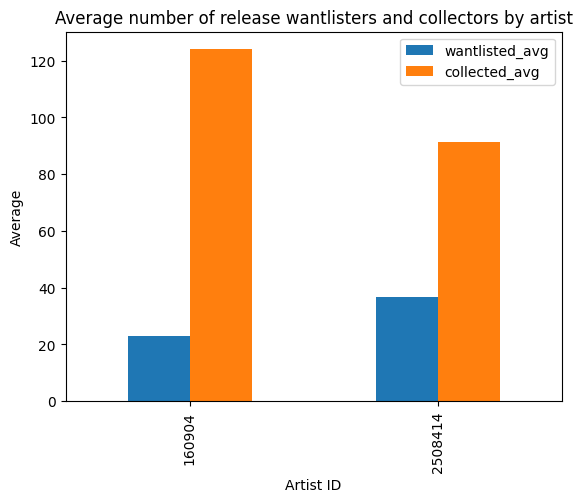

In [22]:
want_collect_fig(my_summary_stats)

In [23]:
def user_wantlist(username, access_token, access_token_secret, consumer_key, consumer_secret, user_agent):
    """
    Returns a dataframe of releases from a user's wantlist with additional details on basic information about the release

    
    Parameters
    ----------
    username : str
        String of the user's username
    access_token : str
        String of the user's access token
    access_token_secret : str
        String of the user's access token secret
    consumer_key : str
        String of the user's unique consumer key
    consumer_secret : str
        String of the user's unique consumer secret
    user_agent : str
        String of the user's user_agent

 
    Returns
    -------
    pandas.DataFrame
        pandas.Dataframe containing release_id, title, year released, artist, genres, etc. of each release within a user's wantlist
    """
     
    # empty dataframe for entire wantlist:
    df = pd.DataFrame()
    page_counter=0 
    # get number of pages of user's wantlist
    access_tokens = oauth.Token(access_token, access_token_secret) # attach OAuth access token and access token secret to request
    consumer = oauth.Consumer(key = consumer_key, secret=consumer_secret)
    client = oauth.Client(consumer, access_tokens)
    r, content = client.request("https://api.discogs.com/users/"+username+"/wants", # artist Releases
                                method = "GET",
                                headers={'User-Agent': user_agent}
                                )
    content_cleaned = json.loads(content.decode('utf-8'))
    pages = content_cleaned['pagination']['pages'] # number of pages

    # create dataframe for user's wantlist for each page
    for i in range(pages):
        page_counter+=1 # page counter
        
        # get wantlist of user and request data
        access_tokens = oauth.Token(access_token, access_token_secret) # attach OAuth access token and access token secret to request
        consumer = oauth.Consumer(key = consumer_key, secret=consumer_secret)
        client = oauth.Client(consumer, access_tokens)
        user_wantlist_url = "https://api.discogs.com/users/"+username+"/wants?page="+str(page_counter)
        r, want_content = client.request(user_wantlist_url, 
                                    method = "GET",
                                    headers={'User-Agent': user_agent}
                                    )
        want_content_cleaned = json.loads(want_content.decode('utf-8')) # convert content to readable format
        
        # create empty DataFrame for each page
        wantlist_df = pd.DataFrame(columns = ["id", "date_added", "basic_information"])

        for i in want_content_cleaned['wants']:
            wantlist_df.loc[len(wantlist_df)] = i # convert each information of a release as a row in a dataframe
        wantlist_df.rename(columns = {'id':'release_id'}, inplace = True)
        # in basic info, search for title
        titles = [re.search("""'title': [\'|\"](.*?)[\'|\"],""", str(s)).group(1) for s in wantlist_df["basic_information"]]   
        wantlist_df['title'] = titles # append wantlisters

        # Year released 
        years = [re.search("year': ([0-9]*),", str(s)).group(1) for s in wantlist_df["basic_information"]]   
        wantlist_df['year'] = years # append year released

        # Artist
        artists = [re.search("""artists': \[\{'name': '(.*)', 'anv':""", str(s)).group(1) for s in wantlist_df["basic_information"]]   
        wantlist_df['artist'] = artists # append release genre

        # Artist ID
        artist_ids = [re.search("'tracks': '', 'id': ([0-9]*), 'resource_url':", str(s)).group(1) for s in wantlist_df["basic_information"]]   
        wantlist_df['artist_id'] = artist_ids # append artist ID
        wantlist_df["artist_id"] = pd.to_numeric(wantlist_df["artist_id"]) #Convert column type to numeric
        
        # Genre
        genres = [re.search("""'genres': (.*?),""", str(s)).group(1) for s in wantlist_df["basic_information"]]   
        wantlist_df['genres'] = genres # append list of genre

        # Style
        styles = [re.search("""'styles': (.*?)""", str(s)).group(1) for s in wantlist_df["basic_information"]]   
        wantlist_df['styles'] = styles # append list of styles
    
        # populate data with full artist data
        df = pd.concat([df, wantlist_df]) 
    return(df)

In [25]:
my_wantlist_df = user_wantlist(my_username, 
                               my_access_token, 
                               my_access_token_secret, 
                               my_consumer_key, 
                               my_consumer_secret, 
                               my_user_agent)

In [26]:
my_wantlist_df.head(10)

,release_id,date_added,basic_information,title,year,artist,artist_id,genres,styles
0,12300593,2022-12-12T19:39:10-08:00,"{'id': 12300593, 'master_id': 4392, 'master_ur...",Physical Graffiti,0,Led Zeppelin,34278,['Rock'],
1,9912415,2022-12-12T19:39:23-08:00,"{'id': 9912415, 'master_id': 38722, 'master_ur...",Rumours,0,Fleetwood Mac,47333,['Rock'],
2,7525118,2022-12-12T20:32:59-08:00,"{'id': 7525118, 'master_id': 4264, 'master_url...",The Smiths,1984,The Smiths,83080,['Rock'],
3,11147950,2022-12-12T19:40:37-08:00,"{'id': 11147950, 'master_id': 24003, 'master_u...",A Hard Day's Night,0,The Beatles,82730,['Rock',
4,8999430,2022-12-12T20:21:09-08:00,"{'id': 8999430, 'master_id': 124850, 'master_u...",If You Can Believe Your Eyes And Ears,0,The Mamas & The Papas,230387,['Rock'],
5,13073436,2022-12-12T20:21:09-08:00,"{'id': 13073436, 'master_id': 124850, 'master_...",If You Can Believe Your Eyes And Ears,0,The Mamas & The Papas,230387,['Rock'],
6,1507288,2022-12-12T20:21:09-08:00,"{'id': 1507288, 'master_id': 124850, 'master_u...",If You Can Believe Your Eyes And Ears,1976,The Mamas & The Papas,230387,['Rock'],
7,3695832,2022-12-12T20:21:09-08:00,"{'id': 3695832, 'master_id': 124850, 'master_u...",If You Can Believe Your Eyes And Ears,1976,The Mamas & The Papas,230387,['Pop',
8,8870915,2022-12-12T20:21:09-08:00,"{'id': 8870915, 'master_id': 124850, 'master_u...",If You Can Believe Your Eyes And Ears,0,The Mamas & The Papas,230387,['Rock'],
9,13538058,2022-12-12T20:21:09-08:00,"{'id': 13538058, 'master_id': 124850, 'master_...",If You Can Believe Your Eyes And Ears,0,The Mamas & The Papas,230387,['Rock'],


In [27]:
def is_release_in_user_wantlist(wantlist_df, releases_df, username):
    """
    Returns a dataframe on artist releases with the addition of a new variable signifying whether a release is in the user's wantlist.

    
    Parameters
    ----------
    wantlist_df : pandas.DataFrame
        pandas.Dataframe containing release_id, title, year released, artist, genres, etc. of each release within a user's wantlist
    releases_df : pandas.Dataframe
        pandas.Dataframe containing release_id, title, artist, year, etc of each release and each artist
    username : str
        String of the user's username

                
    Returns
    -------
    pandas.DataFrame
        pandas.Dataframe containing original information on releases with the additional column indicating if the release is in a user's wantlist   
    """
    releases_df['in_user_wantlist'] = np.where(releases_df['title'].isin(list(wantlist_df['title'])),1 ,0)
    return(releases_df)

In [28]:
my_new_releases_df = is_release_in_user_wantlist(my_wantlist_df, 
                                                 my_releases_df, 
                                                 my_username)
my_new_releases_df.head(5) 

,release_id,title,artist,year,role,artist_id,in_wantlist,in_collection,in_user_wantlist
0,540125,Seals And Crofts,Seals And Crofts*,1969.0,Main,160904,79.0,347.0,0
1,6093218,Cotton Mouth,Seals & Crofts,1970.0,Main,160904,5.0,3.0,0
2,10846567,See My Life / In Tune / Hollow Reed / Leave,Seals And Crofts*,1970.0,Main,160904,2.0,3.0,0
3,1659565,In Tune,Seals & Crofts,1970.0,Main,160904,0.0,0.0,0
4,928474,Gabriel Go On Home / Robin,Seals And Crofts*,1970.0,Main,160904,2.0,6.0,0


In [29]:
# Display the releases that are in my wantlist
my_new_releases_df[my_new_releases_df['in_user_wantlist'] == 1].head(5)

,release_id,title,artist,year,role,artist_id,in_wantlist,in_collection,in_user_wantlist
13,119766,Summer Breeze,Seals & Crofts,1972.0,Main,160904,283.0,6486.0,1
14,684050,Diamond Girl,Seals & Crofts,1973.0,Main,160904,8.0,36.0,1
15,217805,Diamond Girl,Seals & Crofts,1973.0,Main,160904,87.0,5076.0,1
17,119767,Diamond Girl,Seals & Crofts,1973.0,Main,160904,19.0,328.0,1
57,7839193,Diamond Girl,Seals & Crofts,NaN,Main,160904,4.0,10.0,1
